In [1]:
# Importing useful libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
# importing useful objects
from crime_dataset_headers import *
# importing data
data_url= 'https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data'
crime = pd.read_csv(data_url, header=None, names=headers, na_values='?', index_col='communityname')

In [3]:
# Deleting non predictive columns
non_predictive = ['state','county', 'community', 'fold']
crime.drop(non_predictive, axis=1, inplace=True)
# Imputing one missing value !!!! I dont understand
crime.loc['Natchezcity','OtherPerCap'] = crime['OtherPerCap'].mean()
# Deleting columns with majority of missing values (Some of the cols has '?' as a value)
missing_values_per_col = crime.isnull().sum()
cols_to_remove = missing_values_per_col[missing_values_per_col > 0].index
crime.drop(cols_to_remove, axis=1, inplace=True)

In [4]:
X = crime.iloc[:,0:-1]
y = crime.iloc[:,-1]
X,y

(                     population  householdsize  racepctblack  racePctWhite  \
 communityname                                                                
 Lakewoodcity               0.19           0.33          0.02          0.90   
 Tukwilacity                0.00           0.16          0.12          0.74   
 Aberdeentown               0.00           0.42          0.49          0.56   
 Willingborotownship        0.04           0.77          1.00          0.08   
 Bethlehemtownship          0.01           0.55          0.02          0.95   
 ...                         ...            ...           ...           ...   
 TempleTerracecity          0.01           0.40          0.10          0.87   
 Seasidecity                0.05           0.96          0.46          0.28   
 Waterburytown              0.16           0.37          0.25          0.69   
 Walthamcity                0.08           0.51          0.06          0.87   
 Ontariocity                0.20           0.78     

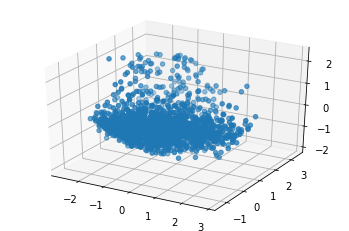

In [5]:
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d

fig = plt.figure()
ax= plt.axes(projection='3d')

pca = PCA(n_components=3)
pca.fit(X)
X_pca = pca.transform(X)

ax.scatter3D(X_pca[:, 0], X_pca[:, 1], X_pca[:,2])
plt.show()

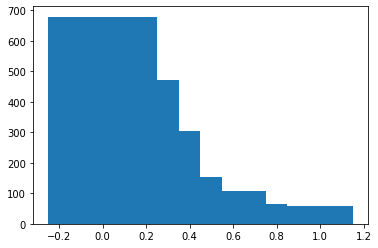

In [6]:
hist, bin_edges = np.histogram(y)
fig = plt.figure()
plt.bar(bin_edges[:-1], hist, width=0.5)
plt.show()

In [7]:

from sklearn.model_selection import train_test_split

split = 0.2 # use 20% of the data for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split)

In [19]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

classifier = XGBRegressor(objective ='reg:squarederror')
grid = {
    'n_estimators': [300, 400, 500, 600],
    'max_depth' : [3, 4, 5],
    'learning_rate' : [0.01]
}

gd_sr = GridSearchCV(estimator=classifier,
                       param_grid=grid,
                       scoring='r2', # note the use of scoring here.
                       cv=5, iid=False)


gd_sr.fit(X_train, y_train)

best_parameters = gd_sr.best_params_
print(best_parameters)

C:\Users\SkyMa\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 600}


In [20]:
best_clf = XGBRegressor(objective='reg:squarederror',
                        n_estimators=best_parameters['n_estimators'], 
                        max_depth=best_parameters['max_depth'], 
                        learning_rate=best_parameters['learning_rate'])

# has best set of parameters, now retrain on all training data.

best_clf.fit(X_train,y_train)

y_pred = best_clf.predict(X_test)
y_pred_tr = best_clf.predict(X_train)

## How did we do

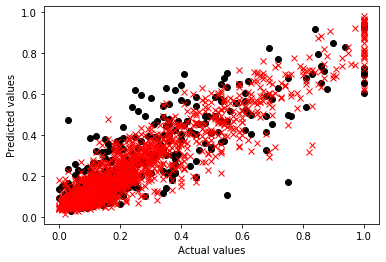

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.plot(y_test, y_pred, 'o', color='black')
plt.plot(y_train,y_pred_tr, 'x', color='red')
plt.show()

In [22]:
from sklearn.metrics import r2_score
# we use r2 because we are doing regression, not classification
print('Training set:',r2_score(y_train,y_pred_tr))
print('Test set:',r2_score(y_test,y_pred))

Training set: 0.8705185942513844
Test set: 0.7451297041780043


## Good! But can we do better?

Scaling down the parameters

In [26]:
from sklearn.feature_selection import SelectKBest, f_regression



# do train-test split to get sample to do feature selection

split= 0.20 # use 20% for feature selection
X_train_FS, X_FS, y_train_FS, y_FS = train_test_split(X_train, y_train, test_size=split)

print('before selecting:', X_train_FS.shape)
skb = SelectKBest(f_regression, k=70)
skb.fit(X_FS,y_FS)
X_train_FS = skb.transform(X_train_FS)
print('after selecting:', X_train_FS.shape)

before selecting: (1276, 100)
after selecting: (1276, 70)


In [ ]:
from sklearn.svm import SVR

classifier = SVR(kernel='linear') 

grid = {
    'C' : [80, 90, 100] 
   }

gd_sr = GridSearchCV(estimator=classifier,
                       param_grid=grid,
                       scoring='r2', # note the use of scoring here.
                       cv=5, iid=False)


gd_sr.fit(X_train_FS, y_train_FS)

best_parameters = gd_sr.best_params_
print(best_parameters)

In [ ]:
best_clf = SVR(kernel='linear',C=best_parameters['C'])
best_clf.fit(X_train,y_train)

y_pred = best_clf.predict(X_test)
y_pred_tr = best_clf.predict(X_train)

In [ ]:
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.plot(y_test, y_pred, 'o', color='black')
plt.plot(y_train,y_pred_tr, 'x', color='red')

plt.show()

In [ ]:
print('Training set:',r2_score(y_train,y_pred_tr))
print('Test set:',r2_score(y_test,y_pred))